<a href="https://colab.research.google.com/github/DomMc97/Weather-Predictions/blob/main/arima_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Univariate Time Series Data Forcasting

In this notebook I use the ARMA model and its adpataptions to predict the minimum daily temperatures in the city Melbourne, Australia. Using a univariate dataset of the minimum daily temperatures over 10 years (1981-1990) in Melbourne from the Australian Bureau of Meteorology.

## Set Up 

Install libraries.

In [1]:
%%capture
!pip install statsmodels
!pip install pmdarima

Imports libaries.

In [2]:
# data analytics library
import pandas as pd

# statsmodels ARIMA model and tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

# library with auto arima model 
from pmdarima import pipeline, preprocessing as ppc, arima, auto_arima

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets design of figures

## Load Data

Loads in the df of temperatures from github.

In [3]:
# load csv from github url
temp_df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/' +
                      'master/daily-min-temperatures.csv')
N, M = temp_df.shape
print('Columns: ', M, '\nRows:', N)
temp_df.head()

Columns:  2 
Rows: 3650


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


# Plot Data

A plot of the minimum temperatures dataset.

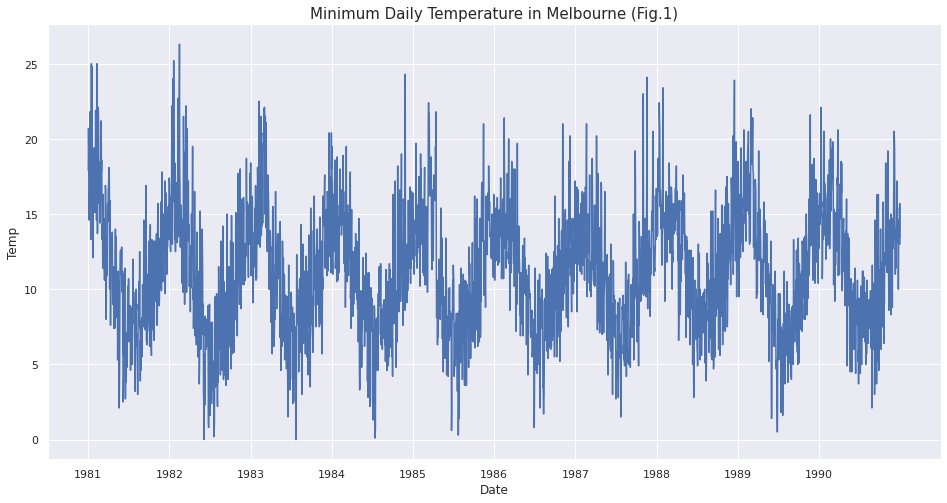

In [4]:
fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(x='Date', y='Temp', data=temp_df)
ax.set_title('Minimum Daily Temperature in Melbourne (Fig.1)', fontsize=15)
years = pd.date_range(start='1981-01-01', end='1990-01-01',freq='AS')
ax.set_xticks(years.strftime('%Y-%m-%d'))
ax.set_xticklabels(years.strftime('%Y'))
plt.show()

## ARIMA

The AutoRegressive Integrated Moving Average (ARIMA) model is a statistical model which is used for forecasting time series data. The ARIMA model is a generalisation of the simpler AutoRegressive Moving Average (ARMA) model which incoparates the notion of intergration for non-stationary processes.

### AR

The AR relates to an autoregressive model which uses uses the dependent relationship between an observation and some number of lagged observations: $$X_{t} = \delta + \phi_{1}X_{t-1}+ \phi_{2}X_{t-2} + \dots + \phi_{p}X_{t-p} + A_{t}$$ where $X_{t}$ is the time series, $A_{t}$ is white noise and $\delta = (1- \sum\limits_{i=1}^{p} \phi_{i})\mu$ with $\mu$ denoting the mean of the process.

An autoregressive model is simply a linear regression of the current value of the series against $p$ prior values of the series. The value of $p$ is called the order of the AR model.

### MA

The MA relates to an moving average model where an observation depends only on the lagged forecast errors: $$X_{t} = \mu + A_{t} - \theta_{1}A_{t-1} - \theta_{2}A_{t-2} - \dots - \theta_{q}A_{t-q}$$ where $X_{t}$ is the time series, $A_{t}$ is the white noise error terms and $\mu$ is the mean of the process.

The error terms $A_{t}$ are found recursively from the previous observations that is to find $A_{t} = X_{t} -\mu + \theta_{1}A_{t-1} + \theta_{2}A_{t-2} + \dots + \theta_{q}A_{t-q}$ we recursively calculate errors from the first term $A_{1} = X_{1} -\mu + \theta_{1}A_{0} + \theta_{2}A_{-1} + \dots + \theta_{q}A_{1-q}$ which is found from an initial estimate of the parameters $\{\theta_{0},\dots, \theta_{q}\}$ and the use of backforecasting or setting to 0 of $\{A_{0}, \dots A_{-q}\}$.

A moving average model is conceptually a linear regression of the current value of the series against the error of $q$ prior values of the series. The errors at each point are assumed to come from the same distribution, typically a normal distribution, with location at zero and constant scale. The distinction in this model is that these errors are propogated to future values of the time series.

### Box-Jenkins

The Box-Jenkins ARMA model is a combination of the AR and MA models: $$X_{t} = \delta + \phi_{1}X_{t-1}+ \phi_{2}X_{t-2} + ... + \phi_{p}X_{t-p} + A_{t} - \theta_{1}A_{t-1} - \theta_{2}A_{t-2} - ... - \theta_{q}A_{t-q}$$

### ARIMA

The ARIMA model additionally incorporates the differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary. If a single diffencing does not make a process stationary we can continually difference until it becomes stationary, the amount of times we apply differncing is called the order of differencing $d$.

Mathematically differencing can be denoted by the following: $$\Delta^{d}(X_t) = \Delta^{d-1}(\Delta(X_{t})) = \dots \text{where } \Delta(X_{t}) = X_{t} - X_{t-1}$$

So if we had a diffencing of $d=2$ we would apply the ARMA model to the series to: $$\Delta^{2}(X_{t}) = \Delta(X_{t} - X_{t-1}) = (X_{t} - X_{t-1}) - (X_{t-1} - X_{t-2}) = X_{t} - 2 X_{t-1} - X_{t-2}$$

### Selecting p, q, d

#### d

Firstly to test whether the model is stationary the Augmeneted Dickey Fuller test can be applied, if the p value is found to be less than 0.05 the process is seen as stationary.

We can additionally plot the autocorrelation of the series(or differenced series). If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

#### p, q

Two diagnostic plots can be used to help choose the p and q parameters of the ARIMA. They are the:


*   **Autocorrelation Function (ACF)** The plot summarises the correlation of an observation with lag values. The x-axis shows the lag and the y-axis shows the correlation coefficient between -1 and 1 for negative and positive correlation.
*  **Partial Autocorrelation Function (PACF)** The plotgives the partial correlation of a stationary time series with its own lagged values.

Some useful patterns to observe on these plots are:

* The model is AR if the ACF trails off after a lag and has a hard cut-off in the PACF after a lag. This lag is taken as the value for $p$.
* The model is MA if the PACF trails off after a lag and has a hard cut-off in the ACF after the lag. This lag value is taken as the value for $q$.
* The model is a mix of AR and MA if both the ACF and PACF trail off.

### Estimation

After the hyperparameters are set numerical methods are used to optimise the parameters.





---












## Determining d

I will firstly investigate whether the process is stationary using the Augmented Dickey Fuller test. 

In [5]:
result = adfuller(temp_df['Temp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.444805
p-value: 0.000247


The p value is less than 0.05 we can therefore conclude that the time series is stationary. This supports the visual appearance of the time series. I will therefore set $d=0$.

The lag subsides fairly quickly, although its seems to be sinusoidal which indicates a seasonality.

## Determining p and q

I now firstly plot the ACF of the time series to determine q.

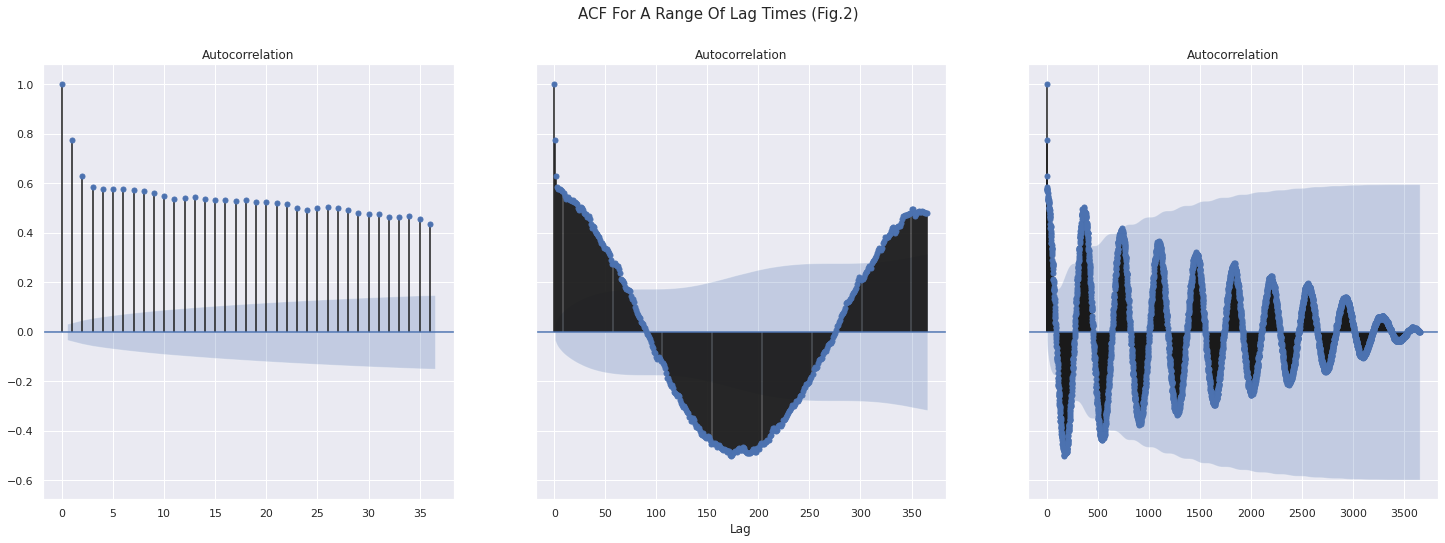

In [6]:
# creates figure
fig, axs = plt.subplots(1, 3 ,sharey=True, figsize=(25, 8))

# sets titles
fig.suptitle('ACF For A Range Of Lag Times (Fig.2)', fontsize=15)
axs[1].set_xlabel('Lag')

# make plots
plot_acf(temp_df['Temp'], ax=axs[0])
plot_acf(temp_df['Temp'], lags=365, ax=axs[1])
plot_acf(temp_df['Temp'], lags=3649, ax=axs[2])

# show plots
plt.show()

We can see that the ACF is sinsodial and slow decays, this suggests firstly that there may be seasonality, as expected for weather data, and that there are no sharp drops in the ACF hence $q=0$.

I will now plot the PACF of the time series to determine p. 

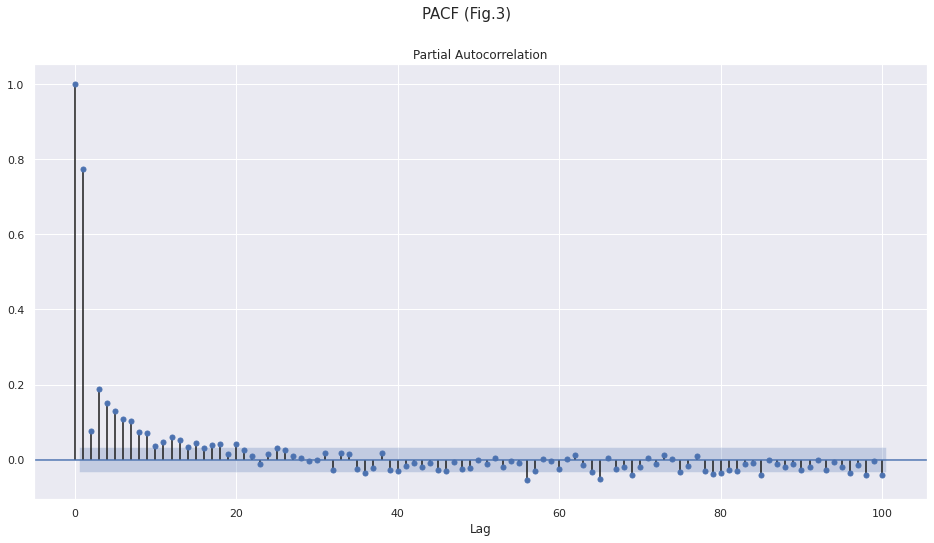

In [7]:
# creates figure
fig, ax = plt.subplots(figsize=(16, 8))

# title
fig.suptitle('PACF (Fig.3)', fontsize=15)
ax.set_xlabel('Lag')

# make plot
plot_pacf(temp_df['Temp'], lags=100, ax=ax)

# show plot
plt.show()

We can see that the PACF drops off sharply at lag of 2 hence we should set $p=2$.

## Estimation 

Now we have chosen the parameters we need to train the model which will be $\text{ARIMA}(2, 0 ,0 ) = \text{AR(2)}$ I will now now optimise the parameters.

In [8]:
# test train split
train = temp_df['Temp'][:3285]
test = temp_df['Temp'][3285:]

# build model
arima_model = ARIMA(train, order=(2, 0, 0))
arima_model = arima_model.fit()

# summary of results
print(arima_model.summary())

                              ARMA Model Results                              
Dep. Variable:                   Temp   No. Observations:                 3285
Model:                     ARMA(2, 0)   Log Likelihood               -7775.040
Method:                       css-mle   S.D. of innovations              2.580
Date:                Mon, 08 Mar 2021   AIC                          15558.080
Time:                        12:11:59   BIC                          15582.469
Sample:                             0   HQIC                         15566.812
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1373      0.217     51.266      0.000      10.711      11.563
ar.L1.Temp     0.7123      0.017     40.950      0.000       0.678       0.746
ar.L2.Temp     0.0808      0.017      4.643      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


See performance on the model on the test data.

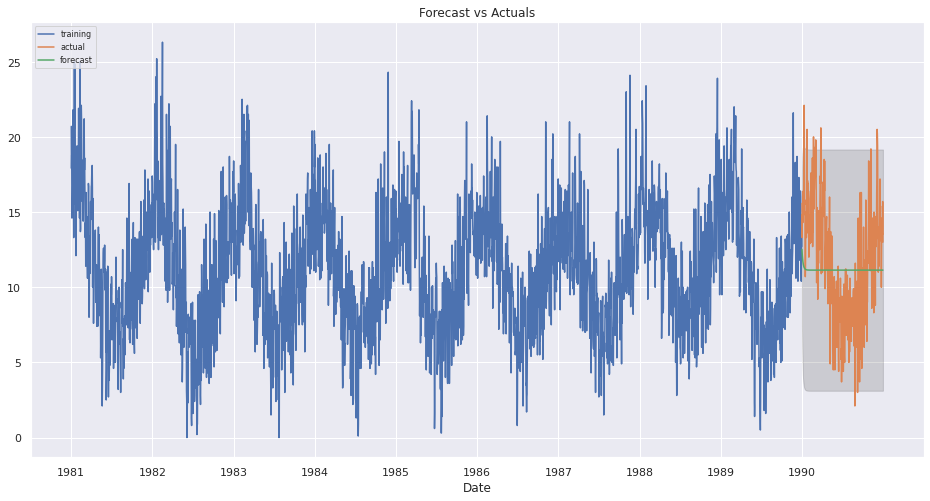

In [9]:
# Forecast
pred, error, conf = arima_model.forecast(365, alpha=0.05)  # 95% conf

# Make pandas series
test_series  = pd.Series(test, index=test.index) 
pred_series = pd.Series(pred, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(16,8))
plt.plot(train, label='training')
plt.plot(test_series, label='actual')
plt.plot(pred_series, label='forecast')

plt.xticks(range(0, 3650, 365),years.strftime('%Y'))
plt.xlabel('Date')

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The predictions are poor this is likely down to the seasonality of the time series and not my parameter choices which is highlighted below with the using of auto arima.

In [10]:
sarima_model = auto_arima(train, start_p=2, start_q=0, seasonal=False)
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3285
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -7566.026
Date:                Mon, 08 Mar 2021   AIC                          15144.051
Time:                        12:12:47   BIC                          15180.634
Sample:                             0   HQIC                         15157.149
                               - 3285                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0561      0.019      2.972      0.003       0.019       0.093
ar.L1          1.4835      0.019     76.179      0.000       1.445       1.522
ar.L2         -0.6135      0.028    -21.881      0.000      -0.668      -0.559
ar.L3          0.1251      0.019      6.698      0.000       0.089       0.162
ma.L1         -0.8932      0.012    -72.154      0.000      -0.917      -0.869
sigma2         5.8590      0.136     43.039      0.000       5.592       6.126
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.92
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.09
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

See performance on the model on the test data.

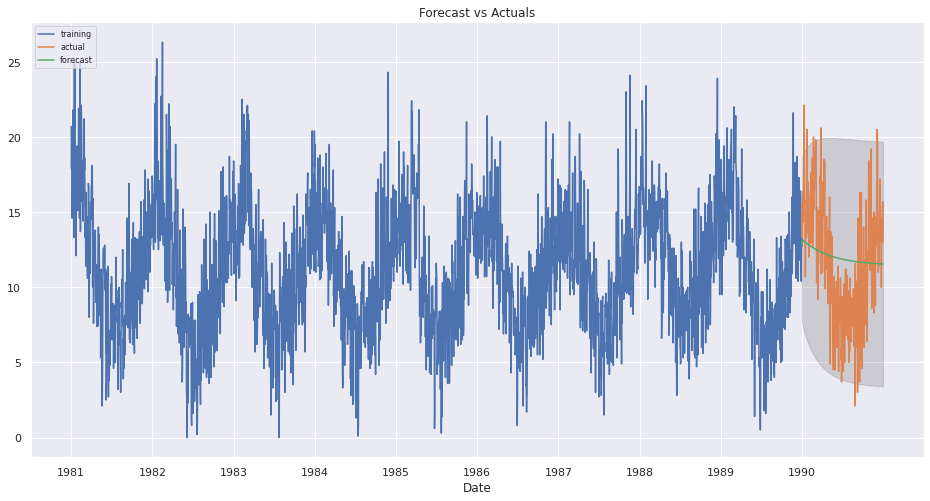

In [11]:
# Forecast
pred, conf = sarima_model.predict(365, return_conf_int=True)  # 95% conf

# Make pandas series
test_series  = pd.Series(test, index=test.index) 
pred_series = pd.Series(pred, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(16,8))
plt.plot(train, label='training')
plt.plot(test_series, label='actual')
plt.plot(pred_series, label='forecast')

plt.xticks(range(0, 3650, 365),years.strftime('%Y'))
plt.xlabel('Date')

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## SARIMA

Seasonal Autoregressive Integrated Moving Average (SARIMA) is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds four new hyperparameters:

* **P:** Seasonal autoregressive order.
* **D:** Seasonal difference order.
* **Q:** Seasonal moving average order.
* **m:** The number of time steps for a single seasonal period



Due to a large $m=365$ however auto arima crashes due to exceeding the RAM usage which occurs with the precomputation of terms (the 365 previous terms). To allow seasonal differencing I will therefore use a Fourier Series approach where the seasonal pattern is modelled using Fourier terms with short-term time series dynamics allowed in the error.

In [12]:
# create a pipeline which firstly performs a fourier transform to the data to
# capture yearly seasonality and then auto fits an ARIMA model to the 
# transformed data 
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=365, k=4)),
    ("arima", arima.AutoARIMA(seasonal=False))
    ])

# fit the pipeline
pipe.fit(train)

# summary of the model
pipe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3285
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -7493.819
Date:                Mon, 08 Mar 2021   AIC                          15011.639
Time:                        12:15:44   BIC                          15084.801
Sample:                             0   HQIC                         15037.834
                               - 3285                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
FOURIER_S365-0     1.7784      0.133     13.364      0.000       1.518       2.039
FOURIER_C365-0     3.8053      0.133     28.573      0.000       3.544       4.066
FOURIER_S365-1     0.3354      0.114      2.952      0.003       0.113       0.558
FOURIER_C365-1    -0.4377      0.111     -3.938      0.000      -0.655      -0.220
FOURIER_S365-2    -0.0883      0.107     -0.823      0.411      -0.299       0.122
FOURIER_C365-2     0.1046      0.110      0.949      0.343      -0.111       0.321
FOURIER_S365-3    -0.1587      0.106     -1.502      0.133      -0.366       0.048
FOURIER_C365-3    -0.2185      0.109     -2.010      0.044      -0.432      -0.005
ar.L1              0.3280      0.033     10.046      0.000       0.264       0.392
ma.L1             -0.7804      0.034    -22.786      0.000      -0.848      -0.713
ma.L2             -0.2051      0.033     -6.192      0.000      -0.270      -0.140
sigma2             5.6130      0.136     41.344      0.000       5.347       5.879
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.63
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

See performance on the model on the test data.

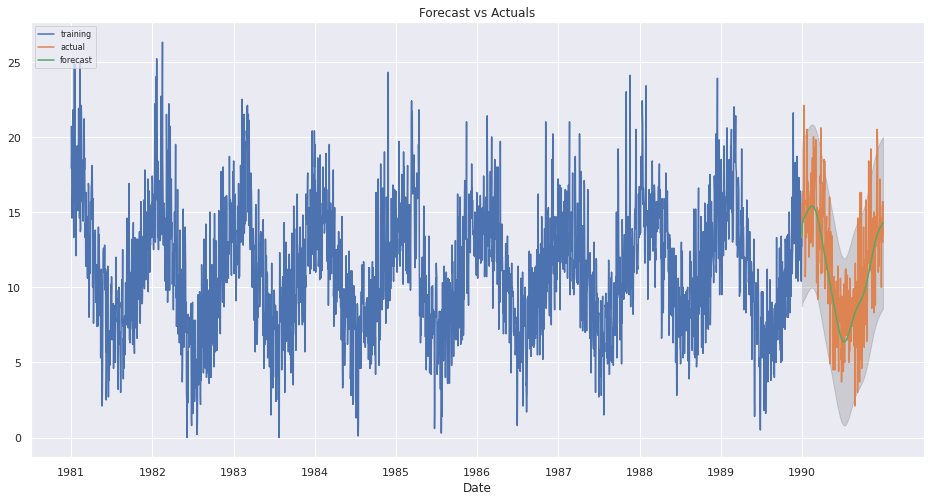

In [13]:
# Forecast
pred, conf =  pipe.predict(365, return_conf_int=True)  # 95% conf

# Make pandas series
test_series  = pd.Series(test, index=test.index) 
pred_series = pd.Series(pred, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(16,8))
plt.plot(train, label='training')
plt.plot(test_series, label='actual')
plt.plot(pred_series, label='forecast')

plt.xticks(range(0, 3650, 365),years.strftime('%Y'))
plt.xlabel('Date')

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

We can see that the inclusion of seasonality greatly improves the performance of the model. 